In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, Adamax
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Read the data

In [ ]:
# Reading CSV file
train = pd.read_csv("/content/gdrive/MyDrive/emnist_byclass_train.csv", nrows=600000).astype('float32')
test = pd.read_csv("/content/gdrive/MyDrive/emnist_byclass_test.csv", nrows=80000).astype('float32')

train=np.array(train)
test=np.array(test)

# There are in total 814255 images each of size 28 X 28 but here we are using only 500000
# Each row in the CSV file contains one image flattern in a vector of size 784
print("train_data: ")
print()
print(train)

print()
print()

print("test_data: ")
print()
print(test)

train_data: 

[[ 5.  0.  0. ...  0.  0.  0.]
 [ 9.  0.  0. ...  0.  0.  0.]
 [14.  0.  0. ...  0.  0.  0.]
 ...
 [49.  0.  0. ...  0.  0.  0.]
 [ 6.  0.  0. ...  0.  0.  0.]
 [ 4.  0.  0. ...  0.  0.  0.]]


test_data: 

[[24.  0.  0. ...  0.  0.  0.]
 [ 2.  0.  0. ...  0.  0.  0.]
 [ 3.  0.  0. ...  0.  0.  0.]
 ...
 [53.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [53.  0.  0. ...  0.  0.  0.]]


# Shuffling the data

In [ ]:
train=shuffle(train)
test=shuffle(test)

# Split the data into image and their labels

In [ ]:
# As it is seen that '0' column contains labels (0,61).
# Split data into images and their labels
train_x=train[:,1:785]
train_y=train[:,0]
test_x=test[:,1:785]
test_y=test[:,0]

print("train_x: ", train_x.shape)
print()
print(train_x)
print()

print("test_x",test_x.shape)
print()
print(test_x)
print()

print("train_y",train_y.shape)
print()
print(train_y)
print()

print("test_y",test_y.shape)
print()
print(test_y)
print()

train_x:  (600000, 784)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

test_x (80000, 784)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

train_y (600000,)

[ 3. 16.  8. ...  4. 24. 15.]

test_y (80000,)

[28.  3.  7. ... 49. 17. 40.]



# Data pre processing


> *Reverse and rotate the data*







In [ ]:
# since the data in emnist by class is rotated and reversed
for i in range(len(train_x)):
  image=train_x[i]
  image=np.array(image)
  image=np.reshape(image,(28,28))
  image=np.transpose(image)
  image=image.flatten()
  train_x[i]=image

for i in range(len(test_x)):
  image=test_x[i]
  image=np.array(image)
  image=np.reshape(image,(28,28))
  image=np.transpose(image)
  image=image.flatten()
  test_x[i]=image

In [ ]:
print(train_x.shape)
print(test_x.shape)

(600000, 784)
(80000, 784)


# Plotting the number of alphabets and digits in the dataset

train_y_integer:  [ 3 16  8 ...  4 24 15]
test_y_integer:  [28  3  7 ... 49 17 40]


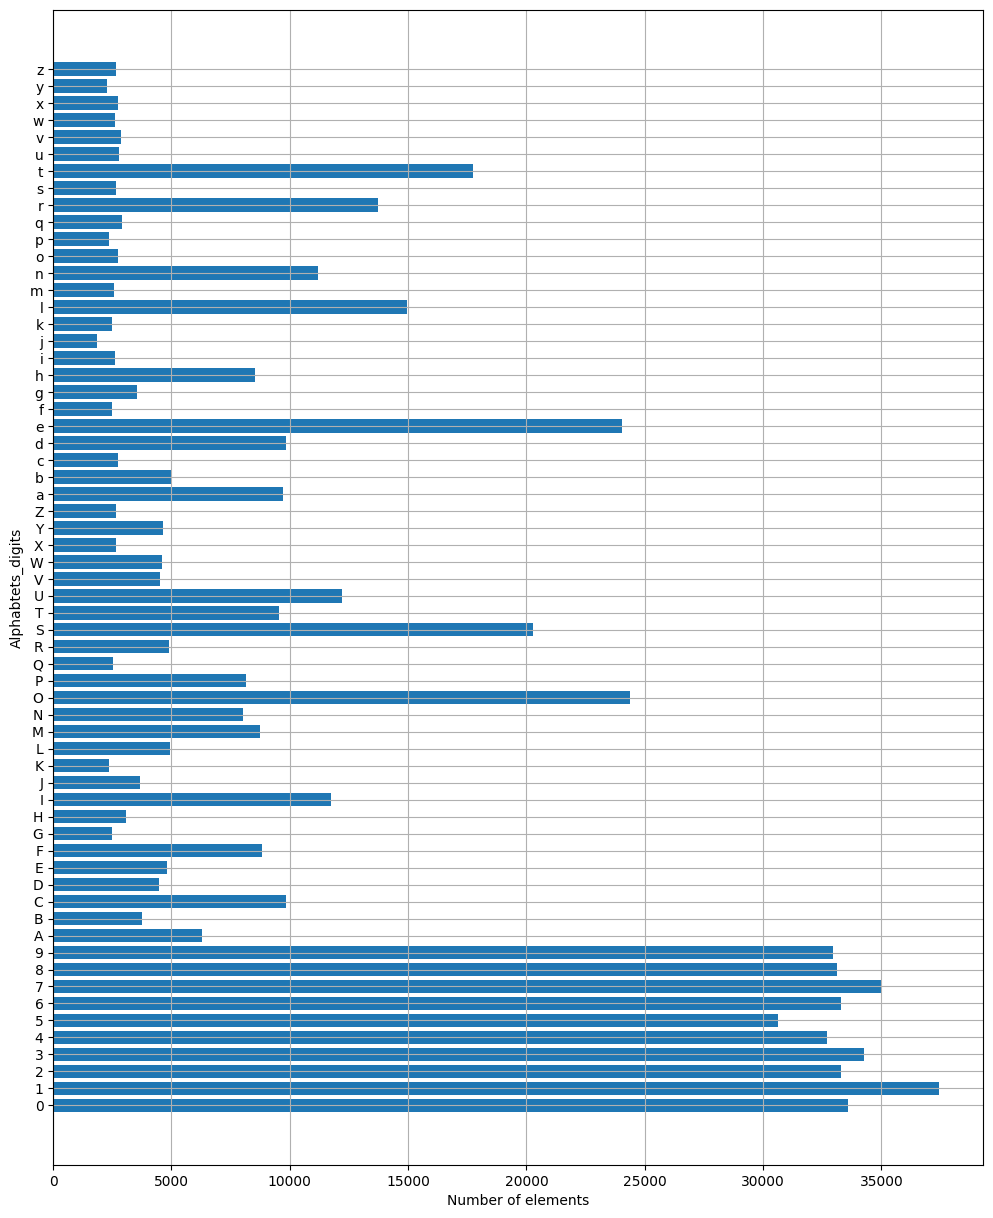

In [ ]:
# We create a dictionary word_dict to map the integer values with the characters.
word_dict = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
             16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N', 24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'c',39:'d',40:'e',41:'f',42:'g',43:'h',44:'i',45:'j',
             46:'k',47:'l',48:'m',49:'n', 50:'o',51:'p',52:'q',53:'r',54:'s',55:'t',56:'u',57:'v',58:'w',59:'x',60:'y',
             61:'z'}


train_y_integer = train_y.astype(int)
test_y_integer = test_y.astype(int)

print("train_y_integer: ", train_y_integer)
print("test_y_integer: ", test_y_integer)


# 'count' is vector of size 26 which keeps count of how many times is that character present in dataset
count = np.zeros(62, dtype='int')
for i in train_y_integer:
    count[i] +=1
for i in test_y_integer:
    count[i] +=1

alphabets_digits = ['0','1','2','3','4','5','6','7','8','9',
                    'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                    'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']


# Plotting the number of each alphabet in the dataset
fig, ax = plt.subplots(1,1, figsize=(12,15))
ax.barh(alphabets_digits, count)   #  'barh' is used to make a horizontal bar plot
plt.xlabel("Number of elements")
plt.ylabel("Alphabtets_digits")
plt.grid()
plt.show()

# Reshaping the Train and Test data

In [ ]:
# Reshaping the training & test DATA so that it can be put in the model
final_train_x = train_x.reshape(train_x.shape[0], 28, 28, 1)
print("New shape of train data: ", final_train_x.shape)

final_test_x = test_x.reshape(test_x.shape[0], 28, 28, 1)
print("New shape of train data: ", final_test_x.shape)
print()


# Reshaping the training & test LABELS so that it can be put in the model
   # to_categorial converts a class vector(integers) to binary class matrix
   # a = to_categorical([0, 1, 1, 3, 2], num_classes=4)
   # print(a)
   # [[1. 0. 0. 0.]
   # [0. 1. 0. 0.]
   # [0. 1. 0. 0.]
   # [0. 0. 0. 1.]
   # [0. 0. 1. 0.]]
final_train_y = to_categorical(train_y, num_classes = 62)  # numclass=62 because labels have values from 0 to 61 only
print("New shape of train labels: ", final_train_y.shape)

final_test_y = to_categorical(test_y, num_classes = 62)    # numclass=62 because labels have values from 0 to 61 only
print("New shape of test labels: ", final_test_y.shape)

New shape of train data:  (600000, 28, 28, 1)
New shape of train data:  (80000, 28, 28, 1)

New shape of train labels:  (600000, 62)
New shape of test labels:  (80000, 62)


# CNN Model

In [ ]:
# CNN model designed for training the model over the training dataset
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))


model.add(Flatten())


# Fully connected layers
model.add(Dense(256,activation ="relu"))
model.add(Dense(512,activation ="relu"))

# Dropout layer
model.add(Dropout(0.5))

# Softmax function for classification
model.add(Dense(62,activation ="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compiling & Fitting the model

In [ ]:
# Compiling and fitting the model
model.compile(optimizer = Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(final_train_x, final_train_y, epochs=25,  validation_data = (final_test_x,final_test_y))

import pickle

with open('emnist_model.pkl', "wb") as f:
  pickle.dump(model, f)

Epoch 1/25
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 95s 5ms/step - accuracy: 0.5935 - loss: 1.7948 - val_accuracy: 0.8323 - val_loss: 0.5018
Epoch 2/25
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 137s 5ms/step - accuracy: 0.8174 - loss: 0.5546 - val_accuracy: 0.8494 - val_loss: 0.4301
Epoch 3/25
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 142s 5ms/step - accuracy: 0.8402 - loss: 0.4664 - val_accuracy: 0.8552 - val_loss: 0.4042
Epoch 4/25
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 138s 5ms/step - accuracy: 0.8499 - loss: 0.4281 - val_accuracy: 0.8608 - val_loss: 0.3873
Epoch 5/25
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - accuracy: 0.8582 - loss: 0.4025 - val_accuracy: 0.8626 - val_loss: 0.3773
Epoch 6/25
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 146s 5ms/step - accuracy: 0.8621 - loss: 0.3832 - val_accuracy: 0.8648 - val_loss: 0.3736
Epoch 7/25
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 139s 5ms/step - accuracy: 0.8661 - loss: 0.3701 - val_accuracy: 0.8669 - val_loss: 0.3676
Epoch 8/25
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 146s 5ms/step - accu

# Model summary

In [ ]:
model.summary()
model.save(r'English.h5')
# from google.colab import files
# files.download("English.h5")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,226,556 (12.31 MB)

 Trainable params: 1,075,518 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,151,038 (8.21 MB)

# Model accuracy and Model loss

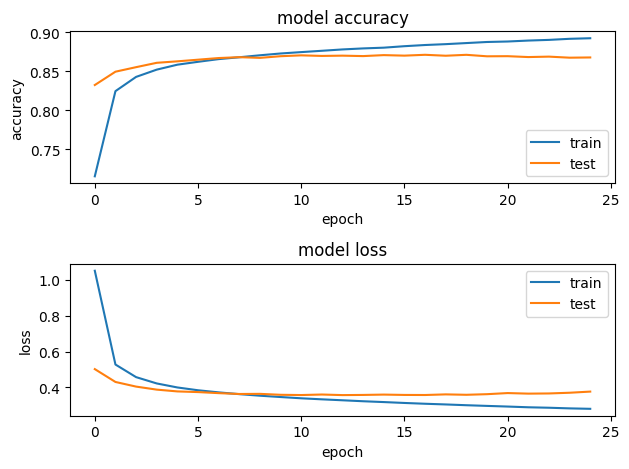

In [ ]:
# Plot accuracy vs epoch
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('English model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

# Plot loss vs epoch
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

# No. of Correct and Incorrect predictions

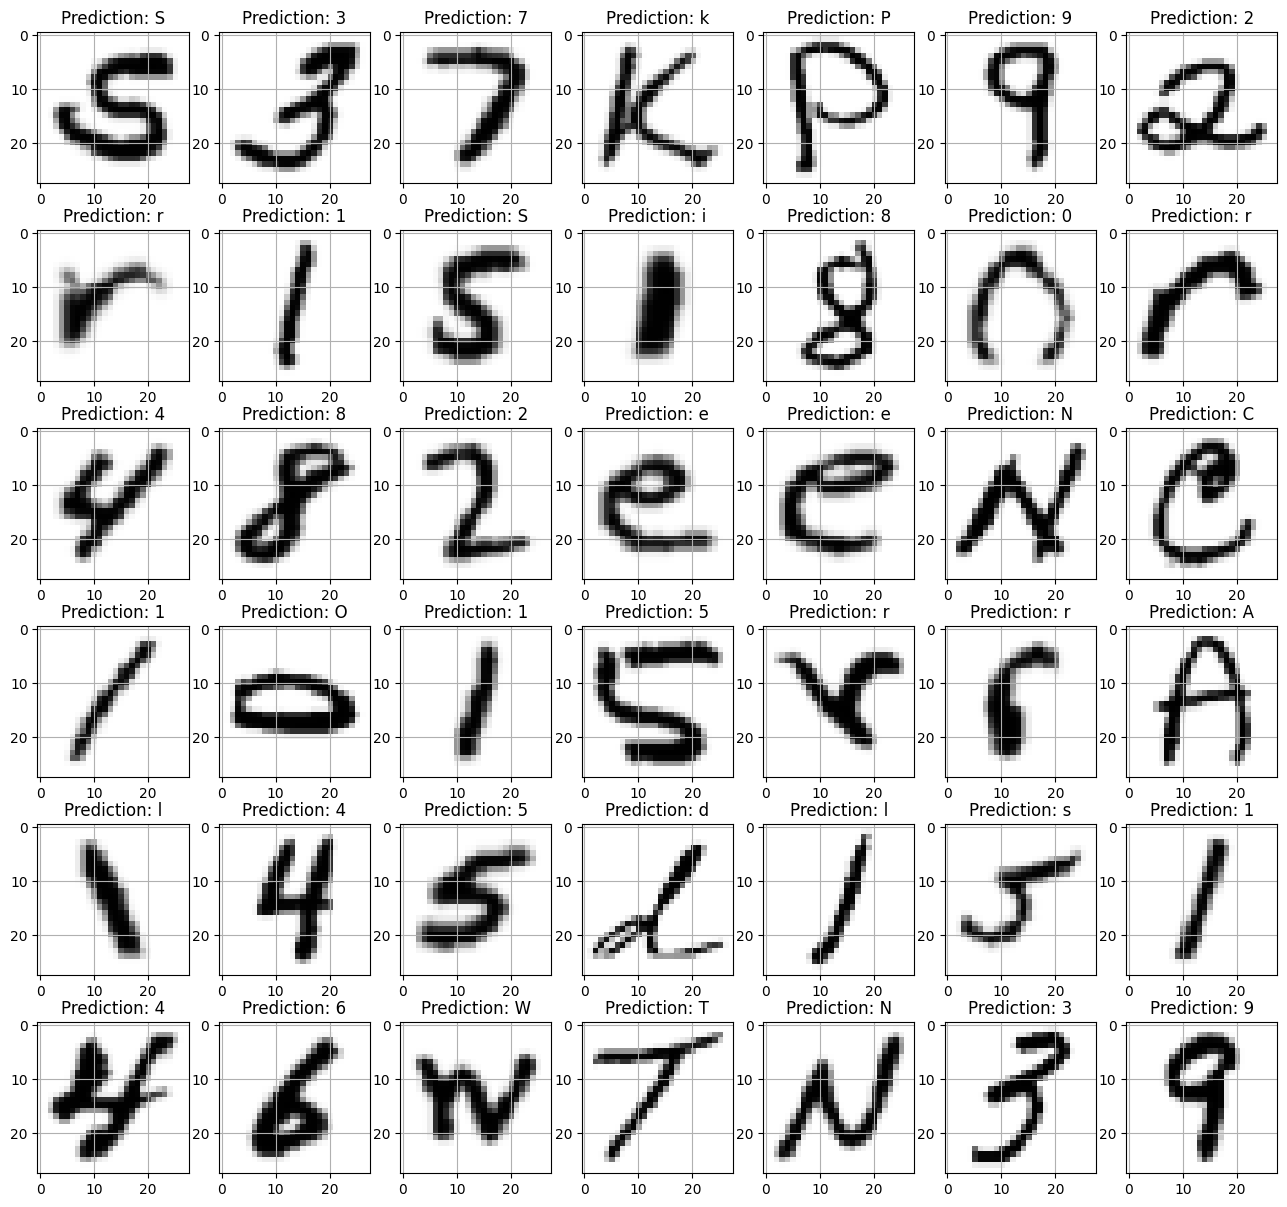

In [ ]:
# Prediction on test dataset
fig, axes = plt.subplots(6,7, figsize=(16,15))
axes = axes.flatten()

for i,ax in enumerate(axes):
    img = np.reshape(final_test_x[i], (28,28))
    #img=np.transpose(img)
    ax.imshow(img, cmap="Greys")

    pred = word_dict[np.argmax(final_test_y[i])]
    ax.set_title("Prediction: "+pred)
    ax.grid()

In [ ]:
predictions = model.predict(final_test_x)
predicted_classes = np.argmax(predictions, axis=1)


# find test images predicted correctly
correct = np.nonzero(predicted_classes == test_y_integer)[0]


# find test images predicted correctly
incorrect = np.nonzero(predicted_classes != test_y_integer)[0]

print()
print("Correctly classified images: ", len(correct))
print("Incorretly classified images: ", len(incorrect))

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Correctly classified images:  69410
Incorretly classified images:  10590


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


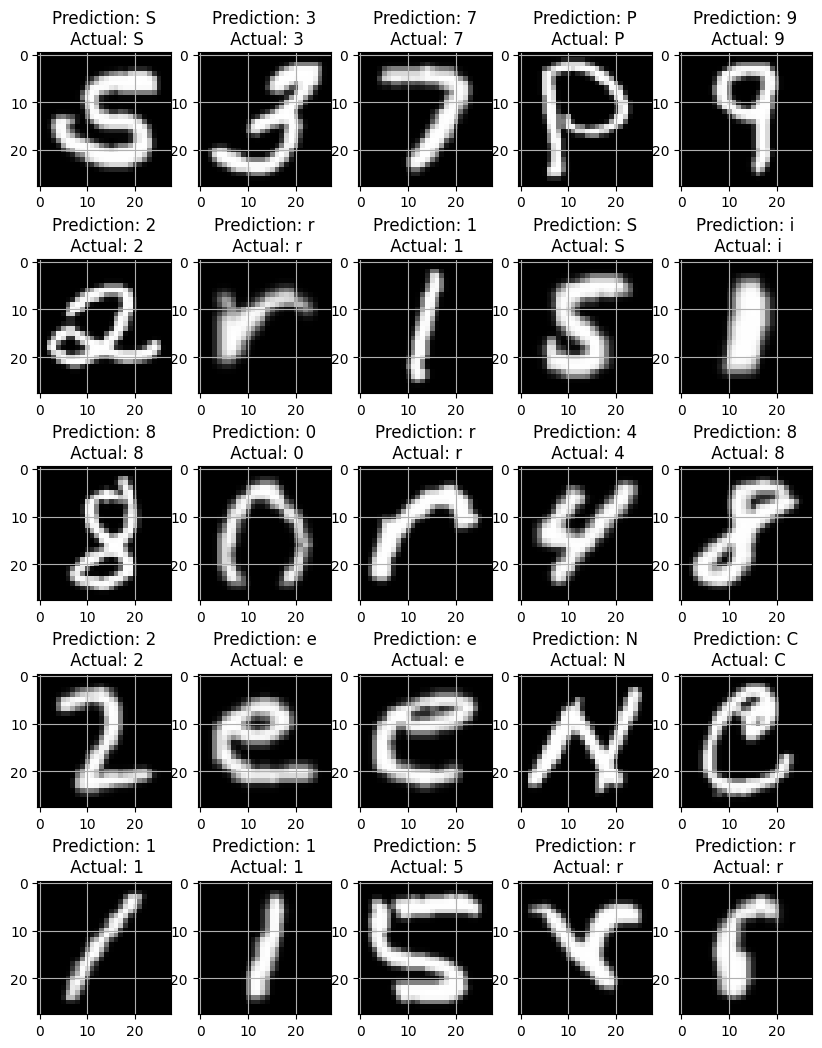

In [ ]:
# Printing few correctly predicting test images
fig, axes = plt.subplots(5,5, figsize=(10,13))
axes = axes.flatten()

for i,ax in enumerate(axes):
    img = np.reshape(final_test_x[correct[i]], (28,28))
    ax.imshow(img, cmap='gray')

    img = np.reshape(final_test_x[correct[i]], (1,28,28,1))
    pred=model.predict(img)
    ans=word_dict[np.argmax(pred)]
    actual=word_dict[test_y_integer[correct[i]]]
    ax.set_title("Prediction: "+ ans +
                 "\n Actual: "+ actual)
    ax.grid()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


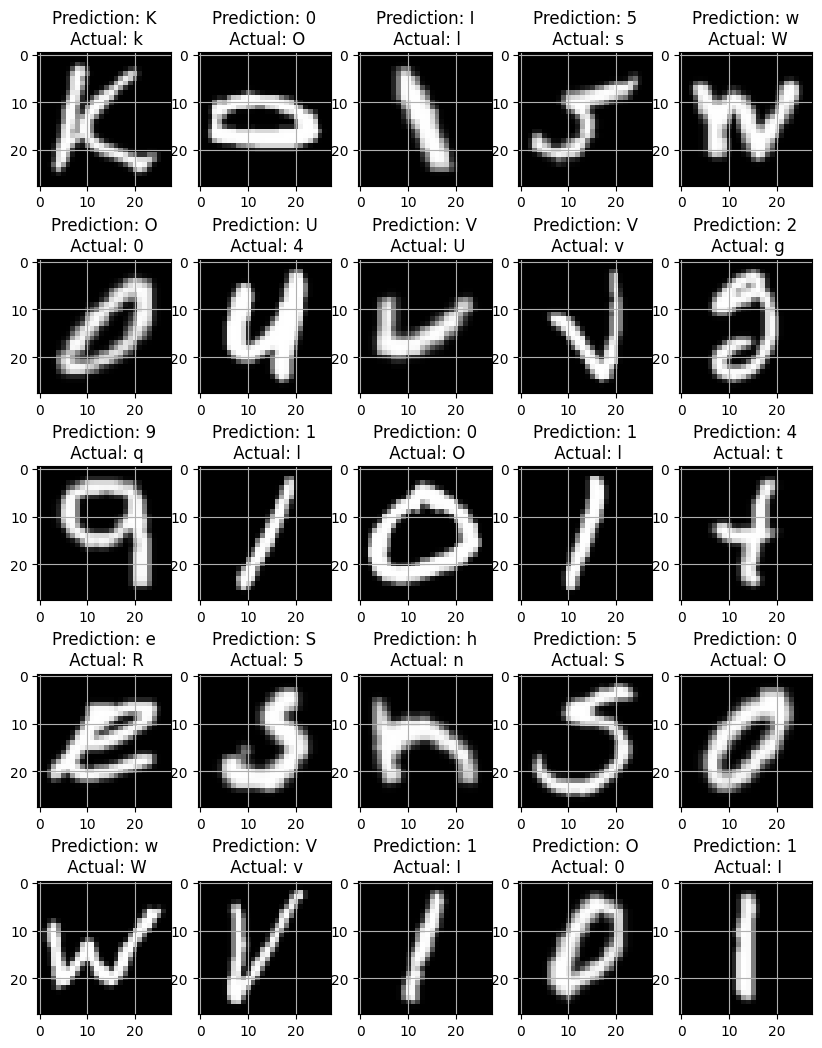

In [ ]:
# Printing few incorrectly predicting test images
fig, axes = plt.subplots(5,5, figsize=(10,13))
axes = axes.flatten()

for i,ax in enumerate(axes):
    img = np.reshape(final_test_x[incorrect[i]], (28,28))
    ax.imshow(img, cmap='gray')

    img = np.reshape(final_test_x[incorrect[i]], (1,28,28,1))
    pred=model.predict(img)
    ans=word_dict[np.argmax(pred)]
    actual=word_dict[test_y_integer[incorrect[i]]]
    ax.set_title("Prediction: "+ ans +
                 "\n Actual: "+ actual)
    ax.grid()